<img src="../../images/arm_logo.png" width=250 alt="ARM Logo"></img>

# The Precipitation Best-Estimate ([PrecipBE](https://www.arm.gov/capabilities/instruments/precipbe)) evaluation value-added product

---

## Overview
This notebook demonstrates the use of the Precipitation Best-Estimate (PrecipBE) evaluation value-added product to visualize and analyze the temporal evolution of precipitation events and precipitation event statistics data from the HOU ([TRACER](https://www.arm.gov/research/campaigns/amf2021tracer)) deployment collected in April, 2022.

1. Introduction to PrecipBE
1. How to access the data and load using Xarray
1. Processing and visualization

---

### Imports

In [1]:
import act
import os
import numpy as np
import xarray as xr
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from time import time
from datetime import datetime

## Overview of PrecipBE

The precipitation best-estimate (precipBE) VAP serves as the go-to precipitation product for the ARM user community. The VAP includes two datastreams streamlining both process understanding and model evaluation studies using ARM precipitation data. The first datastream (precipbetseries) provides time series (evolving) precipitation data, whereas the second includes per-event statistics in an easy-to-use one-dimensional (tabular) format. The VAP processing is performed on a per precipitation-event basis, leveraging existing ARM measurement capabilities, depending on instrument availability (per deployment) while incorporating ARM DQR and data validity considerations. The precipbestats datastream also includes ancillary atmospheric-state data corresponding to each event, such as temperature, relative humidity, and a selected set of drop size distribution moments derived from [ARM disdrometer quantities VAPs](https://doi.org/10.2172/1808573) (where available).

As an evaluation VAP, it is requested that data users communicate closely with the VAP points of contact, particularly regarding any issues.

## How to Access PrecipBE Data from ARM

### Use the ARM Live API to Download the Data, using ACT

The Atmospheric Data Community Toolkit (ACT) has a helpful module to interface with the data server:
* [Download Data API](https://arm-doe.github.io/ACT/API/generated/act.discovery.html#module-act.discovery)

### Setup our Download Query
Before downloading our data, we need to make sure we have an ARM Data Account, and ARM Live token. Both of these can be found using this link:
- [ARM Live Signup](https://adc.arm.gov/armlive/livedata/home)

Once you sign up, you will see your token. Copy and replace that where we have `arm_username` and `arm_password` below.

We will also need the two datastream names, which are `houprecipbetseriesM1.c1` (time series of precipitation events) and `houprecipbestatsM1.c1` (precipitation event statistics), representing:
- the site (HOU) and facility (M1)
    - This information corresponds to the TRACER main site at Houston
- the product class (precipbe)
    - This is the value-added product described in this notebook 
- the product type (tseries and stats)
    - Those are the two datasets derived from this product 
- the data level (c1)
    - This is the corrected, quality-controlled data 

In [2]:
arm_username = os.getenv("ARM_USERNAME")
arm_password = os.getenv("ARM_PASSWORD")

tseries_datastream = "houprecipbetseriesM1.c1"
stats_datastream = "houprecipbestatsM1.c1"

start_date = "2022-04-01T00:00:00"
end_date = "2022-04-30T23:59:00"

tseries_files = act.discovery.download_arm_data(arm_username,
                                             arm_password,
                                             tseries_datastream,
                                             start_date,
                                             end_date)

stats_files = act.discovery.download_arm_data(arm_username,
                                             arm_password,
                                             stats_datastream,
                                             start_date,
                                             end_date)

[DOWNLOADING] houprecipbetseriesM1.c1.20220426.000000.nc
[DOWNLOADING] houprecipbetseriesM1.c1.20220429.000000.nc
[DOWNLOADING] houprecipbetseriesM1.c1.20220417.000000.nc
[DOWNLOADING] houprecipbetseriesM1.c1.20220414.000000.nc
[DOWNLOADING] houprecipbetseriesM1.c1.20220419.000000.nc
[DOWNLOADING] houprecipbetseriesM1.c1.20220423.000000.nc
[DOWNLOADING] houprecipbetseriesM1.c1.20220405.000000.nc
[DOWNLOADING] houprecipbetseriesM1.c1.20220407.000000.nc
[DOWNLOADING] houprecipbetseriesM1.c1.20220420.000000.nc
[DOWNLOADING] houprecipbetseriesM1.c1.20220421.000000.nc
[DOWNLOADING] houprecipbetseriesM1.c1.20220408.000000.nc
[DOWNLOADING] houprecipbetseriesM1.c1.20220406.000000.nc
[DOWNLOADING] houprecipbetseriesM1.c1.20220422.000000.nc
[DOWNLOADING] houprecipbetseriesM1.c1.20220415.000000.nc
[DOWNLOADING] houprecipbetseriesM1.c1.20220411.000000.nc
[DOWNLOADING] houprecipbetseriesM1.c1.20220416.000000.nc
[DOWNLOADING] houprecipbetseriesM1.c1.20220430.000000.nc
[DOWNLOADING] houprecipbetserie

As demonstrated in the output of the previous cell, PrecipBE time series datastreams include files for any given day, regardless of whether surface precipitation was measured. In contrast, the statistics datastreams include files only for days during which one or more precipitation events have started. For example, a TRACER precipitation event that began on 2022-04-25 and continued into 2022-04-26, which we will illustrate below, is recorded on the `houprecipbestatsM1.c1` data file for 2022-04-25. In this case, there is no file for 2022-04-26 since no precipitation events Began on that date.

### Read and examine data files

In [3]:
tseries_final = xr.open_mfdataset(tseries_files)
stats_final = xr.open_mfdataset(stats_files)

---

We can start by examining the time series dataset. This dataset provides the instrument-mean, min, max, and standard deviation of cumulative precipitation (per event) and 1-min precipitation rates, and is accompanied by various useful flags as well as the 1-min precipitation amount measured by all available instruments

In [4]:
tseries_final

<xarray.Dataset> Size: 12MB
Dimensions:                                  (time: 43200, input_inst: 11)
Coordinates:
  * time                                     (time) datetime64[ns] 346kB 2022...
Dimensions without coordinates: input_inst
Data variables: (12/21)
    precipitation_rate                       (time) float64 346kB dask.array<chunksize=(512,), meta=np.ndarray>
    cumulative_precipitation                 (time) float64 346kB dask.array<chunksize=(480,), meta=np.ndarray>
    num_instruments                          (time) float32 173kB dask.array<chunksize=(1440,), meta=np.ndarray>
    single_instrument_flag                   (time) float32 173kB dask.array<chunksize=(1440,), meta=np.ndarray>
    available_instruments                    (time) float64 346kB dask.array<chunksize=(720,), meta=np.ndarray>
    instrument_invalid_samples_during_event  (time) float64 346kB dask.array<chunksize=(720,), meta=np.ndarray>
    ...                                       ...
    precipitation_amount_all_source          (time, input_inst) float32 2MB dask.array<chunksize=(1, 11), meta=np.ndarray>
    time_offset                              (time) datetime64[ns] 346kB dask.array<chunksize=(480,), meta=np.ndarray>
    base_time                                (time) datetime64[ns] 346kB 2022...
    lat                                      (time) float64 346kB 29.67 ... 2...
    lon                                      (time) float64 346kB -95.06 ... ...
    alt                                      (time) float64 346kB 8.0 ... 8.0
Attributes: (12/31)
    data_buffer_days:                                        7
    event_total_minimum_mm:                                  0.1
    event_total_minimum_mm_for_tbrg:                         1.5
    allowed_precip_free_period_min:                          30
    remove_outliers:                                         1
    event_aggregation_mode:                                  0
    ...                                                      ...
    datastream:                                              houprecipbetseri...
    data_level:                                              c1
    facility_id:                                             M1
    site_id:                                                 hou
    platform_id:                                             precipbetseries
    history:                                                 created by user ...

We can also examine the precipitation event statistics dataset we collected. Based on the `time` dimension, 11 precipitation events were observed in April, 2022. This dataset provides an extensive set of statistics characterizing each event (total amount, period, mean precipitation rate, and 1-min maximum precipitation rate). The dataset also includes a useful set of ancillary variables corresponding to the observed events, which will be demonstrated below.

In [5]:
stats_final

<xarray.Dataset> Size: 9kB
Dimensions:                                     (time: 11)
Coordinates:
  * time                                        (time) datetime64[ns] 88B 202...
Data variables: (12/108)
    event_period                                (time) float64 88B dask.array<chunksize=(1,), meta=np.ndarray>
    event_start                                 (time) float64 88B dask.array<chunksize=(1,), meta=np.ndarray>
    event_end                                   (time) float64 88B dask.array<chunksize=(1,), meta=np.ndarray>
    event_mean_rate                             (time) float64 88B dask.array<chunksize=(1,), meta=np.ndarray>
    event_max_rate                              (time) float64 88B dask.array<chunksize=(1,), meta=np.ndarray>
    event_total                                 (time) float64 88B dask.array<chunksize=(1,), meta=np.ndarray>
    ...                                          ...
    total_droplet_concentration_std             (time) float64 88B dask.array<chunksize=(1,), meta=np.ndarray>
    time_offset                                 (time) datetime64[ns] 88B dask.array<chunksize=(1,), meta=np.ndarray>
    base_time                                   (time) datetime64[ns] 88B 202...
    lat                                         (time) float64 88B 29.67 ... ...
    lon                                         (time) float64 88B -95.06 ......
    alt                                         (time) float64 88B 8.0 ... 8.0
Attributes: (12/31)
    data_buffer_days:                                        7
    event_total_minimum_mm:                                  0.1
    event_total_minimum_mm_for_tbrg:                         1.5
    allowed_precip_free_period_min:                          30
    remove_outliers:                                         1
    event_aggregation_mode:                                  0
    ...                                                      ...
    datastream:                                              houprecipbestats...
    data_level:                                              c1
    facility_id:                                             M1
    site_id:                                                 hou
    platform_id:                                             precipbestats
    history:                                                 created by user ...

### Analysis and visualization

---

We can examine (and export) joint distributions of different statistics (here we utilize seaborn, so we need to convert the statistics dataset to a pandas DataFrame). Note that we also plot two ancillary variables,`temp_mean` and `total_droplet_concentration_mean`, which are the event-mean temperature and event-mean estimated droplet number concentration calculated using [MET](https://www.arm.gov/capabilities/instruments/met) and [VDISQUANTS](https://www.arm.gov/data/science-data-products/vaps/vdisquants) data, respectively.

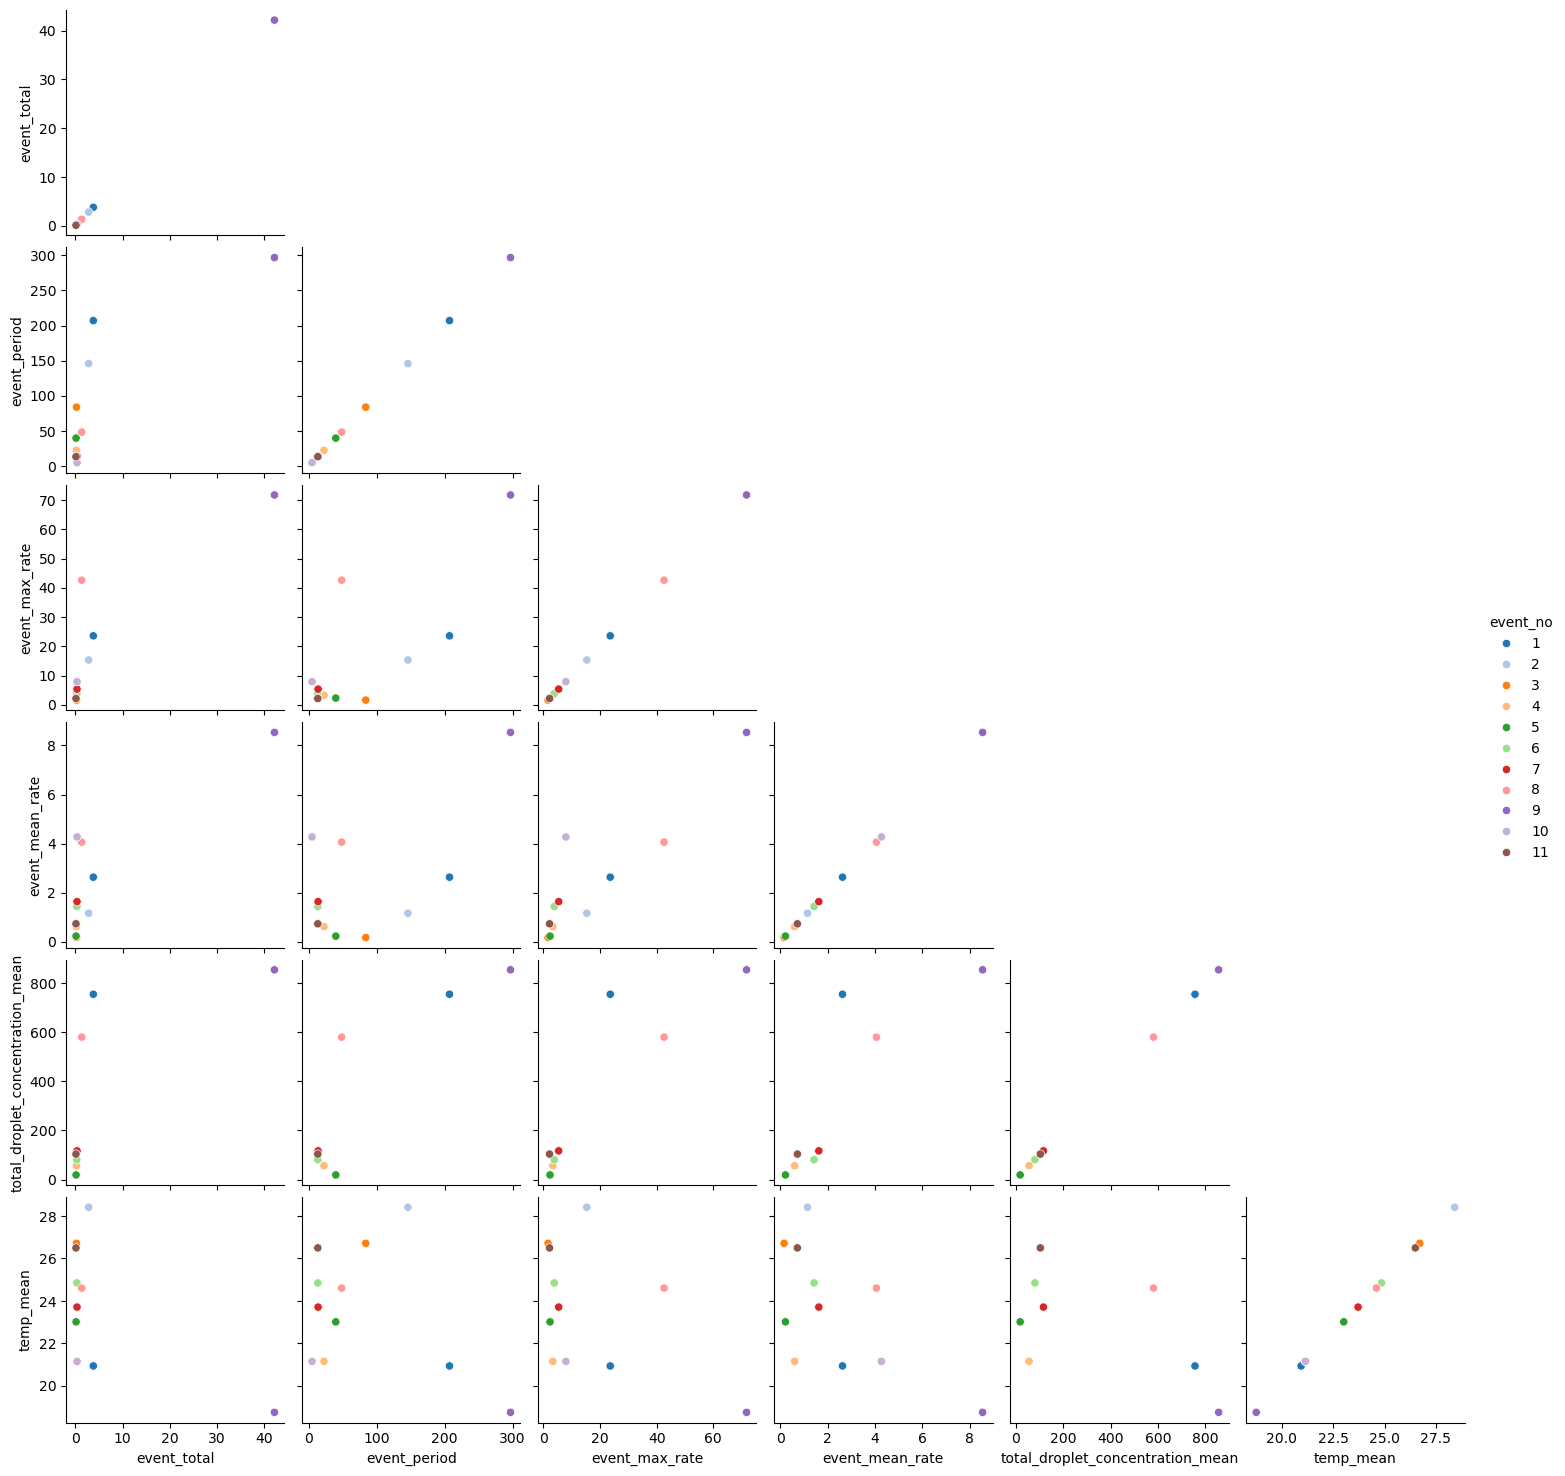

In [7]:
plots_path = './'
stats_df = stats_final.to_pandas()  # convert to a dataframe
stats_df["event_no"] = np.arange(1, len(stats_df) + 1)  # add an event index for easy identification
vars_to_plot = ["event_total",
                "event_period",
                "event_max_rate",
                "event_mean_rate",
                "total_droplet_concentration_mean",
                "temp_mean"
               ]  # variables to plot

Jhist = sns.pairplot(stats_df, vars=vars_to_plot, kind="scatter", corner=True, diag_kind=None, hue="event_no", palette="tab20")
Jhist.fig.savefig(plots_path + "precipbe_joint_hist.png")

Say we are interested in the most significant event in this dataset, which we'll define, for simplicity, as the event with the highest total precipitation. Based on the plot above, we can see that event #9 (indicated by the purple marker) stands out. In comparison to the other events observed in April 2022, this event was also the longest, with the highest precipitation rates and estimated droplet number concentrations, and was characterized by the lowest temperatures.
We want to examine the event's temporal evolution (e.g., did rain fall at a relatively uniform rate or did it occur in short downpour instances?). We begin by finding that event (based on the fact that it had the highest total amount) and its onset and end times.

In [8]:
event_df = stats_df.loc[stats_df["event_total"].idxmax(), :]
print(f'Event began at {(event_df["event_start"].astype("timedelta64[s]") + np.datetime64(event_df["base_time"]))}'
      f'and ended at {(event_df["event_end"].astype("timedelta64[s]") + np.datetime64(event_df["base_time"]))}')

Event began at 2022-04-25T20:36:01.000000and ended at 2022-04-26T01:32:44.000000


We can get part of the answer to the question raised above concerning precipitation rate uniformity even before we plot the time series by evaluating the event's precipitation rate standard deviation.

In [13]:
print(f"The event's precipitation rate standard deviation is {event_df['event_rate_std']:.2f} {stats_final['event_rate_std'].attrs['units']}, "
      f"~{event_df['event_mean_rate'] / event_df['event_rate_std'] * 100:.0f}% of the mean rate")

The event's precipitation rate standard deviation is 11.05 mm/hr, ~77% of the mean rate


With this information we suspect that the event was quite variable and non-uniform. To conclude this brief demo. let's generate two plots depicting the event's evolution from the cumulative and 1-min precipitate rate perspectives.

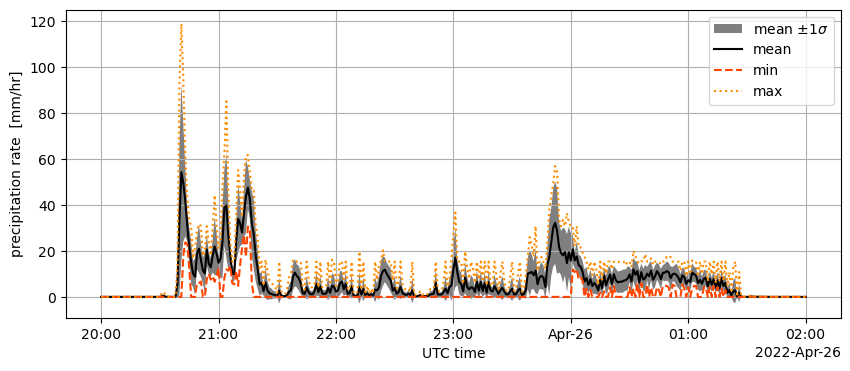

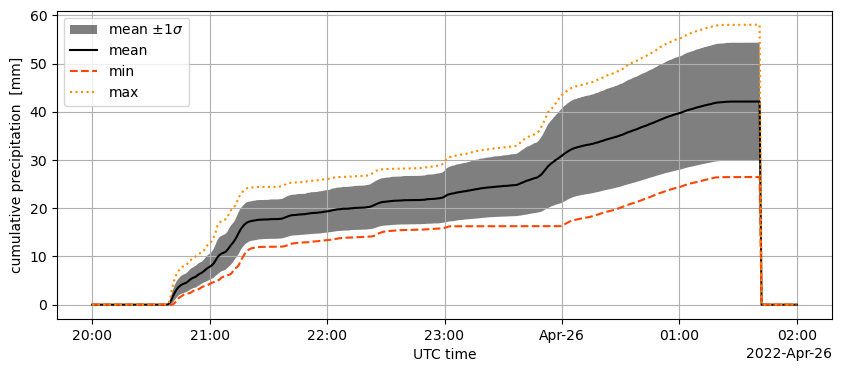

In [33]:
plot_stime = np.datetime64('2022-04-25T20:00:00')
plot_etime = np.datetime64('2022-04-26T02:00:00')
tseries_set = tseries_final.sel(time=slice(plot_stime, plot_etime))
for var in ["precipitation_rate", "cumulative_precipitation"]:
    fig, ax = plt.subplots(figsize=(10, 4))  # for poster
    ax.fill_between(tseries_set["time"].values,
                    tseries_set[f"{var}"].values - tseries_set[f"{var}_std"],
                    tseries_set[f"{var}"].values + tseries_set[f"{var}_std"],
                    facecolor='k',
                    alpha=0.5,
                    label=r"mean $\pm 1\sigma$")
    tseries_set[f"{var}"].plot(c='k', label='mean')
    tseries_set[f"{var}_min"].plot(c='OrangeRed', linestyle='--', label='min')
    tseries_set[f"{var}_max"].plot(c='DarkOrange', linestyle=':', label='max')
    ax.grid('all')
    ax.legend()
    ax.set_ylabel(f'{var.replace("_", " ")}  [{tseries_set[var].attrs["units"]}]')
    ax.set_xlabel(r"UTC time")
    fig.savefig(f"apr25_event_{var}.png", dpi=150)